If the project is run on colab, the following command should be executed to install the required packages that do not come with the available colab environment.

In [ ]:
!pip install opencv-python-headless tensorflow gdown

In [2]:
# imports
import gdown
import os

import numpy as np
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.transform import swirl, resize
from skimage.draw import disk

from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [5]:
batch_size = 32
epochs = 50
img_size = 128

In [3]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [6]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

In [7]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

The following function generate a different swirl effect for each image.

In [8]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

### Getting computed weights

In [9]:
def get_weights(link, output_path):
  print(f"\nDownloading from: {link}")
  gdown.download(link, output_path, fuzzy=True)
  print(f"Weights downloaded in: {output_path}")

# weights for the mask prediction
link_maskNet_weights = 'https://drive.google.com/file/d/1M78wiHI7KVt72re5xeqzsV1YZ_uykNAO/view?usp=sharing'
mask_predictor_weights_path = 'maskpredictor_weights.weights.h5'
get_weights(link_maskNet_weights, mask_predictor_weights_path)

# weights for the inpainting network
link_correctNet_weights = 'https://drive.google.com/file/d/1W9LwLbePn2-Q46gH170RphgCT4I9i_pO/view?usp=sharing'
correction_predictor_weights_path = 'inpaint_weights.weights.h5'
get_weights(link_correctNet_weights, correction_predictor_weights_path)

Downloading...
From: https://drive.google.com/uc?id=1M78wiHI7KVt72re5xeqzsV1YZ_uykNAO
To: /Users/matildesimonini/Documents/Unibo/year 1/sem 2/Deep Learning/Exam_08-07-25/maskpredictor_weights.weights.h5
100%|██████████| 16.1M/16.1M [00:00<00:00, 32.7MB/s]


Weights downloaded in: maskpredictor_weights.weights.h5



Downloading...
From: https://drive.google.com/uc?id=1W9LwLbePn2-Q46gH170RphgCT4I9i_pO
To: /Users/matildesimonini/Documents/Unibo/year 1/sem 2/Deep Learning/Exam_08-07-25/inpaint_weights.weights.h5
100%|██████████| 32.3M/32.3M [00:01<00:00, 30.9MB/s]

Weights downloaded in: inpaint_weights.weights.h5


# Data preparation

The provided generator has been modified to include data augmentation, in order to increase the size and diversity of the training dataset. The chosen augmentation strategy consists of randomly flipping each data sample — horizontally, vertically, and both. As a result, the dataset size is effectively increase by a factor 4.

The generator is designed to create the training, validation, and test sets for both the mask prediction model and the image correction model.
The model for the mask prediction doesn't use data augmentation, which has been introduced only for the the correction model.

In [10]:
def all_flip_combinations(image, mask):
    """Generate all 4 possible flip combinations"""
    combinations = []

    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()

    # Original
    combinations.append(np.concatenate([image, mask], axis=-1))

    # Horizontal flip
    img_h = np.fliplr(image)
    mask_h = np.fliplr(mask)
    combinations.append(np.concatenate([img_h, mask_h], axis=-1))

    # Vertical flip
    img_v = np.flipud(image)
    mask_v = np.flipud(mask)
    combinations.append(np.concatenate([img_v, mask_v], axis=-1))

    # Both horizontal and vertical
    img_hv = np.flipud(np.fliplr(image))
    mask_hv = np.flipud(np.fliplr(mask))
    combinations.append(np.concatenate([img_hv, mask_hv], axis=-1))

    return combinations

In [12]:
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    """
    - If res="all": returns (defected_img + mask, clean_img + mask)
    - If res="mask_detection": returns (defected_img, mask)
    """
    def __init__(self, images, batch_size, shuffle=True, res="all", data_aug=False):
        self.images = np.array(images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.res = res
        self.train = data_aug
        self.indices = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size] # pick all the indices of the samples belonging to batch idx
        current_batch_size = len(batch_indices)

        batch_clean_raw = self.images[batch_indices]
        batch_clean = tf.image.convert_image_dtype(batch_clean_raw, dtype=tf.float32).numpy()

        batch_defected_list = []
        batch_masks_list = []
        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected_list.append(swirled)
            batch_masks_list.append(mask)

        batch_defected = np.array(batch_defected_list)
        batch_masks_raw = np.array(batch_masks_list)
        h, w = batch_masks_raw.shape[1], batch_masks_raw.shape[2]
        batch_masks_reshaped = batch_masks_raw.reshape(current_batch_size, h, w, 1)

        if self.res == "mask_detection":
            return batch_defected, batch_masks_reshaped

        elif self.res == "all":
            x_batch = np.concatenate([batch_defected, batch_masks_reshaped], axis=-1)
            y_batch = np.concatenate([batch_clean, batch_masks_reshaped], axis=-1)

            if self.train:
                x_batch_aug = []
                for x in x_batch:
                    x_batch_aug.extend(all_flip_combinations(x[..., :3], x[..., 3:]))
                y_batch_aug = []
                for y in y_batch:
                    y_batch_aug.extend(all_flip_combinations(y[..., :3], y[..., 3:]))
                return np.array(x_batch_aug), np.array(y_batch_aug)
            else:
                return x_batch, y_batch

        else:
            raise ValueError(f"Invalid value for 'res': {self.res}")

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

In [14]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

test_gen = SwirlDefectGenerator(test_imgs, batch_size=32,res="all")

3670


(32, 128, 128, 4)


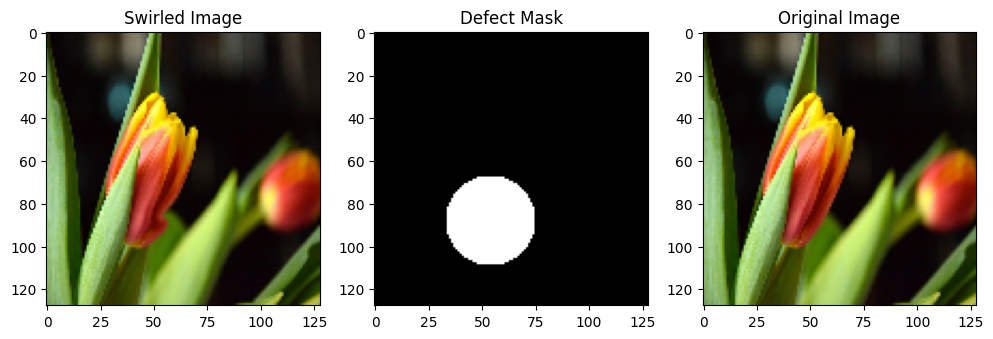

In [19]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_clean = test_gen[idx]
print(y_clean.shape)
y_mask = y_clean[:,:,:,3:]
y_clean = y_clean[:,:,:,:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0][:, :, :3])
plt.title("Swirled Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()

# Building Models

A two-stage deep learning pipeline is used to restore defected images. The task is divided into two subproblems:
- Mask Prediction: a U-Net-like architecture is trained to identify the degraded regions by predicting a binary mask from the input image.
- Image Correction: a second U-Net-like structure model takes the original degraded image and the predicted mask as input and outputs the corrected image.

## Stage 1: Building Mask Prediction Network

The loss used to train the mask predictor combines Binary Cross-Entropy (BCE) with Dice Loss to improve the quality of binary mask predictions.

- BCE is used to penalize incorrect pixel-wise classifications, encouraging accurate per-pixel predictions.

- Dice Loss evaluates the overlap between predicted and true masks, promoting correct mask shape and contour.

By summing both, the model benefits from pixel-level precision (BCE) and global shape consistency (Dice) — leading to more accurate and robust mask segmentation.

Intersection over Union (IoU), is used as a metric to evaluate the quality of the predicted mask.

In [20]:
def combined_mask_loss(y_true, y_pred):
    """
    Binary crossentropy combined with Dice loss for better mask prediction
    """
    # Binary crossentropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Dice loss for shape accuracy
    smooth = 1e-6
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    dice_loss = 1 - dice

    return bce + dice_loss

In [21]:
def iou_metric(y_true, y_pred, threshold=0.5):
    """Intersection over Union (IoU) metric."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred_binary = tf.cast(tf.greater(y_pred, threshold), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_binary)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_binary) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

### Mask predictor architecture
The built model is based on the encoder-decoder architecture.  
It integrates attention modules and gated skip connections to enhance feature extraction and fusion.

- **Encoder**: three downsampling blocks with convolution and channel attention.
- **Bottleneck**: deep features with increased filters and channel attention.
- **Decoder**: three upsampling blocks using transposed convolutions, gated skip connections, to restore resolution.
- **Output**: a 1-channel mask predicted via a sigmoid-activated 1×1 convolution.

In [22]:
def conv_module(x, filters, name=None):
    x = layers.BatchNormalization(name=f"{name}_bn1" if name else None)(x)
    x = layers.Activation('relu', name=f"{name}_relu1" if name else None)(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same', name=f"{name}_conv1" if name else None)(x)
    return x

def channel_attention_module(x, ratio=16):
    channels = x.shape[-1]
    squeeze = layers.GlobalAveragePooling2D()(x)
    squeeze = layers.Dense(channels // ratio, activation='relu')(squeeze)
    excite = layers.Dense(channels, activation='sigmoid')(squeeze)
    excite = layers.Reshape((1, 1, channels))(excite)
    return layers.Multiply()([x, excite])

def spatial_focus_module(x):
    avg = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_ = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = tf.concat([avg, max_], axis=-1)
    attn_map = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    return x * attn_map

def gated_skip_connection(skip, decoder_signal):
    channels = skip.shape[-1]
    g = layers.Conv2D(channels, kernel_size=1, padding='same')(decoder_signal)
    s = layers.Conv2D(channels, kernel_size=1, padding='same')(skip)
    g = layers.BatchNormalization()(g)
    s = layers.BatchNormalization()(s)

    combined = layers.Activation('relu')(g + s)
    alpha = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(combined)

    return skip * alpha

In [23]:
def build_mask_predictor(input_shape, base_ch=28):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = conv_module(inputs, base_ch, name="enc1a")
    x1 = conv_module(x1, base_ch, name="enc1b")
    x1 = channel_attention_module(x1)
    p1 = layers.MaxPooling2D()(x1)

    x2 = conv_module(p1, base_ch * 2, name="enc2a")
    x2 = conv_module(x2, base_ch * 2, name="enc2b")
    x2 = channel_attention_module(x2)
    p2 = layers.MaxPooling2D()(x2)

    x3 = conv_module(p2, base_ch * 4, name="enc3a")
    x3 = conv_module(x3, base_ch * 4, name="enc3b")
    x3 = channel_attention_module(x3)
    p3 = layers.MaxPooling2D()(x3)

    # Bottleneck
    b = conv_module(p3, base_ch * 8, name="bottleneck1")
    b = conv_module(b, base_ch * 8, name="bottleneck2")
    b = channel_attention_module(b)

    # Decoder
    d3 = layers.Conv2DTranspose(base_ch * 4, 2, strides=2, padding='same')(b)
    s3 = gated_skip_connection(x3, d3)
    d3 = layers.Concatenate()([d3, s3])
    d3 = conv_module(d3, base_ch * 4, name="dec3a")
    d3 = conv_module(d3, base_ch * 4, name="dec3b")

    d2 = layers.Conv2DTranspose(base_ch * 2, 2, strides=2, padding='same')(d3)
    s2 = gated_skip_connection(x2, d2)
    d2 = layers.Concatenate()([d2, s2])
    d2 = conv_module(d2, base_ch * 2, name="dec2a")
    d2 = conv_module(d2, base_ch * 2, name="dec2b")

    d1 = layers.Conv2DTranspose(base_ch, 2, strides=2, padding='same')(d2)
    s1 = gated_skip_connection(x1, d1)
    d1 = layers.Concatenate()([d1, s1])
    d1 = conv_module(d1, base_ch, name="dec1a")
    d1 = conv_module(d1, base_ch, name="dec1b")

    output = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(d1)

    return tf.keras.Model(inputs=inputs, outputs=output, name="mask_predictor_model")

In [24]:
train_gen_mask = SwirlDefectGenerator(train_imgs, batch_size=32, res="mask_detection")
val_gen_mask = SwirlDefectGenerator(val_imgs, batch_size=32, res="mask_detection")
test_gen_mask = SwirlDefectGenerator(test_imgs, batch_size=32,res="mask_detection")
mask_predictor = build_mask_predictor(input_shape=(IMG_SIZE, IMG_SIZE, 3), base_ch=26)
mask_predictor.summary()

Model: "mask_predictor_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1a_bn1           │ (None, 128, 128,  │         12 │ input_layer[0][0] │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1a_relu1         │ (None, 128, 128,  │          0 │ enc1a_bn1[0][0]   │
│ (Activation)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1a_conv1         │ (None, 128, 128,  │        728 │ enc1a_relu1[0][0] │
│ (Conv2D)            │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1b_bn1           │ (None, 128, 128,  │        104 │ enc1a_conv1[0][0] │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1b_relu1         │ (None, 128, 128,  │          0 │ enc1b_bn1[0][0]   │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1b_conv1         │ (None, 128, 128,  │      6,110 │ enc1b_relu1[0][0] │
│ (Conv2D)            │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 26)        │          0 │ enc1b_conv1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         27 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 26)        │         52 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 26)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ enc1b_conv1[0][0… │
│                     │ 26)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2a_bn1           │ (None, 64, 64,    │        104 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2a_relu1         │ (None, 64, 64,    │          0 │ enc2a_bn1[0][0]   │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2a_conv1         │ (None, 64, 64,    │     12,220 │ enc2a_relu1[0][0] │
│ (Conv2D)            │ 52)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2b_bn1           │ (None, 64, 64,    │        208 │ enc2a_conv1[0][0] │
│ (BatchNormalizatio… │ 52)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2b_relu1         │ (None, 64, 64,    │          0 │ enc2b_bn1[0][0] 

 Total params: 1,313,897 (5.01 MB)

 Trainable params: 1,310,927 (5.00 MB)

 Non-trainable params: 2,970 (11.60 KB)

The mask predictor was trained with three callbacks to optimize performance: ReduceLROnPlateau reduces learning rate when validation IoU plateaus, EarlyStopping prevents overfitting by stopping training after 7 epochs without IoU improvement, and ModelCheckpoint saves the best weights. The model was trained for up to 50 epochs, with IoU as the validation metric since it effectively measures mask prediction accuracy by calculating overlap between predicted and ground truth masks.

In [ ]:
mask_predictor.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=combined_mask_loss,
    metrics=['accuracy', iou_metric]
)

mask_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_iou_metric',
        patience=3,
        factor=0.5,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou_metric',
        patience=7,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),

    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_mask_predictor.weights.h5',
        monitor='val_iou_metric',
        save_best_only=True,
        save_weights_only=True,
        mode='max'
    )
]

mask_history = mask_predictor.fit(
    train_gen_mask,
    validation_data=val_gen_mask,
    epochs=50,
    callbacks=mask_callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752479923.478284     101 service.cc:148] XLA service 0x7f805480ea20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752479923.479207     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752479925.762221     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/93 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5165 - iou_metric: 0.1019 - loss: 1.5911    

I0000 00:00:1752479942.674302     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8410 - iou_metric: 0.0955 - loss: 1.1580

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 70s 303ms/step - accuracy: 0.8412 - iou_metric: 0.0963 - loss: 1.1568 - val_accuracy: 0.4305 - val_iou_metric: 0.1552 - val_loss: 2.4565 - learning_rate: 0.0010
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 269ms/step - accuracy: 0.8783 - iou_metric: 0.2870 - loss: 0.8942 - val_accuracy: 0.5798 - val_iou_metric: 0.1823 - val_loss: 2.2348 - learning_rate: 0.0010
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.8905 - iou_metric: 0.3279 - loss: 0.8277 - val_accuracy: 0.7035 - val_iou_metric: 0.2037 - val_loss: 1.3736 - learning_rate: 0.0010
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.8976 - iou_metric: 0.3560 - loss: 0.7823 - val_accuracy: 0.6743 - val_iou_metric: 0.2286 - val_loss: 1.6688 - learning_rate: 0.0010
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.9097 - iou_metric: 0.4163 - loss: 0.7009 - val_accuracy: 0.8031 - val_iou_metric: 0.3061 - val_loss: 1.0696 - learning_rate: 0.0010
Epoch 6/50
93/93

Loading the pre-trained weights.

In [25]:
mask_predictor = build_mask_predictor(input_shape=(IMG_SIZE, IMG_SIZE, 3), base_ch=26)
mask_predictor.load_weights(mask_predictor_weights_path)

mask_predictor.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=combined_mask_loss,
    metrics=['accuracy', iou_metric]
)


Evaluation on test set
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.9897 - iou_metric: 0.9129 - loss: 0.0798

--- RESULTS ---
Loss on Test Set: 0.0832
Accuracy on Test Set: 0.9893
Mean IoU on Test Set: 0.9082
--------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


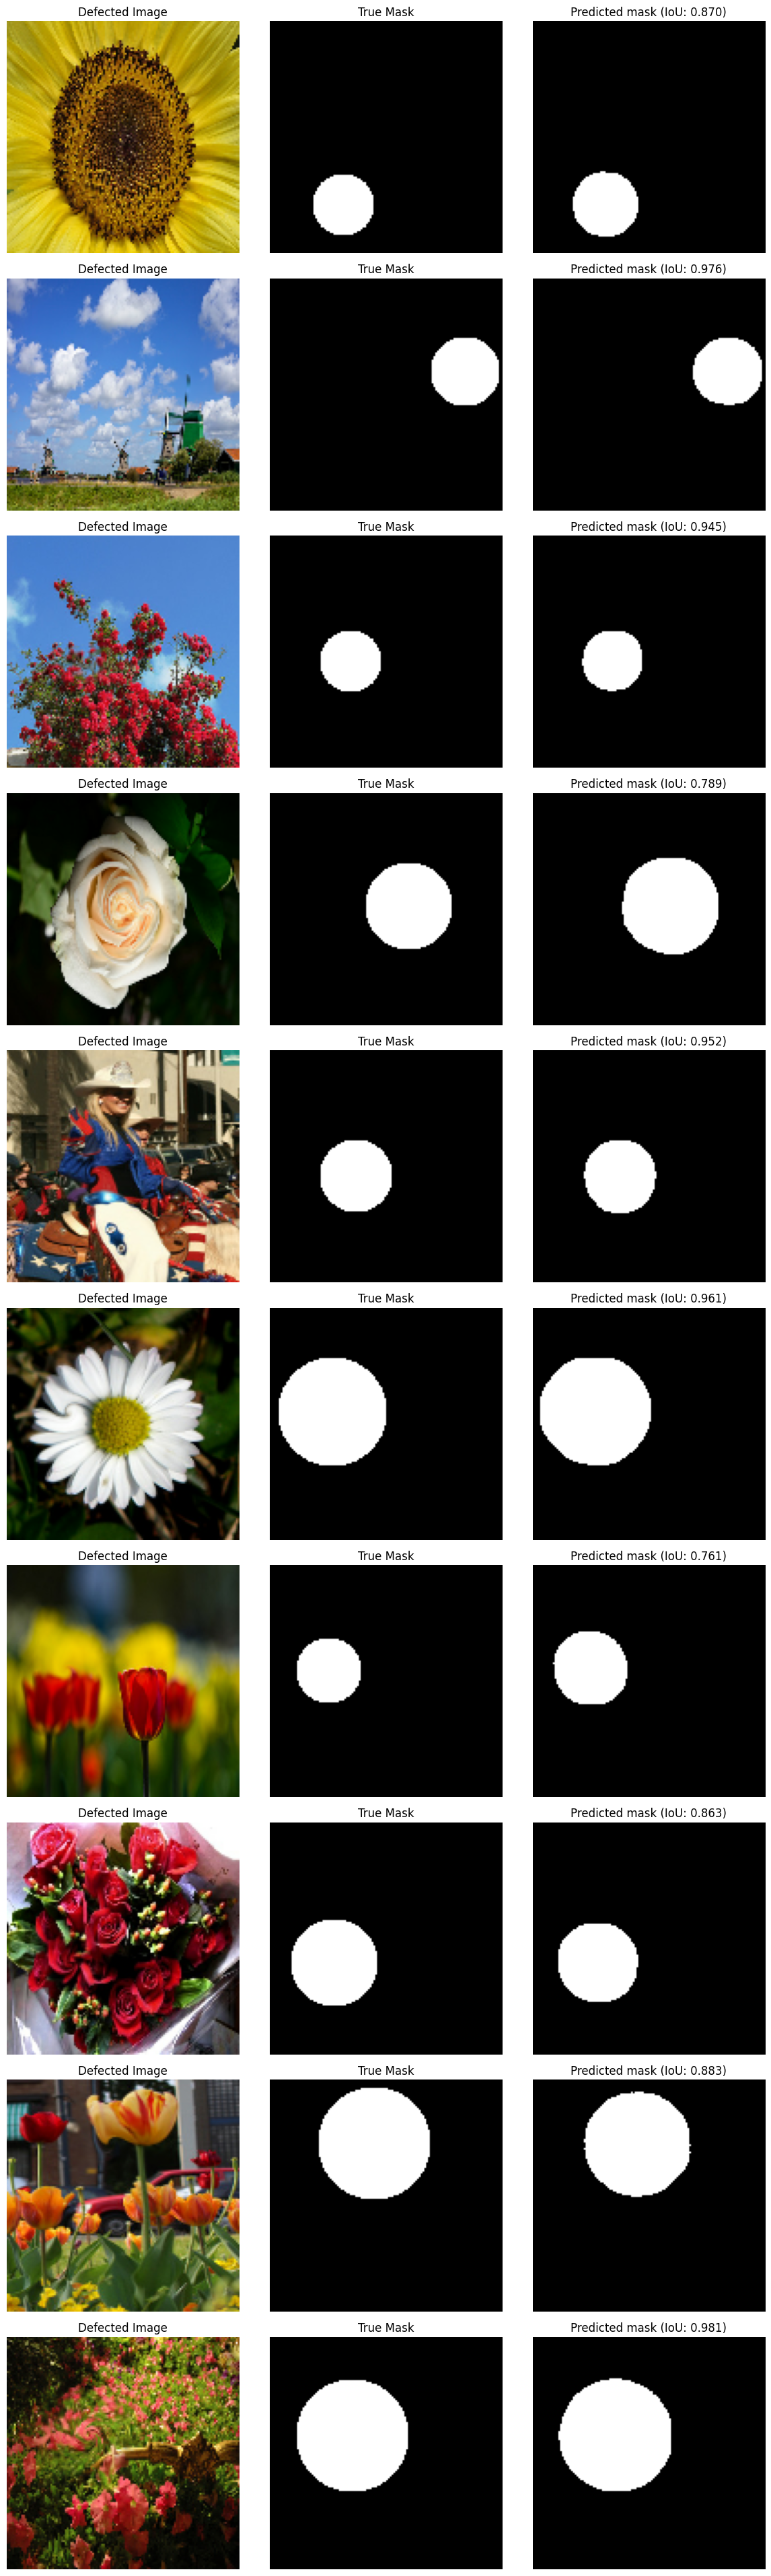

In [47]:
# ==============================================================================
#                      NUMERICAL EVALUATION
# ==============================================================================

model_to_evaluate = mask_predictor

test_gen_mask = SwirlDefectGenerator(test_imgs, batch_size=batch_size, shuffle=False, res="mask_detection")
print("\n" + "="*50)
print("Evaluation on test set")
print("="*50)

results = model_to_evaluate.evaluate(test_gen_mask)

print("\n--- RESULTS ---")
print(f"Loss on Test Set: {results[0]:.4f}")
print(f"Accuracy on Test Set: {results[1]:.4f}")
print(f"Mean IoU on Test Set: {results[2]:.4f}") 
print("-" * 26)


# ==============================================================================
#                      Showing examples
# ==============================================================================

x_batch_test, y_mask_true_batch = next(iter(test_gen_mask))

y_mask_pred_batch = model_to_evaluate.predict(x_batch_test)

num_images_to_show = 10
plt.figure(figsize=(12, 4 * num_images_to_show))

for i in range(num_images_to_show):
    ax1 = plt.subplot(num_images_to_show, 3, i * 3 + 1)
    ax1.imshow(x_batch_test[i])
    ax1.set_title("Defected Image")
    ax1.axis('off')

    ax2 = plt.subplot(num_images_to_show, 3, i * 3 + 2)
    ax2.imshow(y_mask_true_batch[i].squeeze(), cmap='gray')
    ax2.set_title("True Mask")
    ax2.axis('off')

    single_iou = iou_metric(y_mask_true_batch[i], y_mask_pred_batch[i]).numpy()

    ax3 = plt.subplot(num_images_to_show, 3, i * 3 + 3)
    ax3.imshow((y_mask_pred_batch[i] > 0.5).squeeze(), cmap='gray')
    ax3.set_title(f"Predicted mask (IoU: {single_iou:.3f})")
    ax3.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])

Test set evaluation confirms robust generalization in predicting the mask. The visual comparison shows the model accurately predicts the circular defect region, with the predicted mask closely matching the ground truth mask, indicating effective learning of the swirl defect pattern.

## Stage 2: Network for the Correction

In this case the custom loss function is created so that it focuses more on the defected area than the rest of the image. This choice comes from the fact that by training the network using the common mse loss function, the network tends to focus on the non-defected area.
The custom loss considers both the defected and non-defected areas, but gives more weight to the defected one.

The value of alpha is a hyperparameter that can be tuned. It controls the weight of the defected area in the loss function. A value of 0.5 means that both areas are equally important, while a value of 1 means that only the defected area is considered.

In [30]:
def weighted_loss(y_true, y_pred):
    alpha=0.90
    clean = y_true[..., :3]
    mask = y_true[..., 3:]

    # MSE over the whole image
    loss_global = tf.reduce_mean(tf.square(clean - y_pred))

    # MSE over the defected region only
    loss_local = tf.reduce_sum(tf.square(clean - y_pred) * mask) / (tf.reduce_sum(mask) + 1e-8)

    # Weighted sum
    return alpha * loss_local + (1 - alpha) * loss_global

### Inpaint Network architecture

The inpainting network uses a U-Net architecture with skip connections to restore swirl-defected images. The network takes 4-channel input (RGB image + binary mask) and outputs a corrected 3-channel RGB image. Skip connections are implemented through concatenation operations that connect encoder features directly to corresponding decoder layers. This design choice is crucial for inpainting tasks because most pixels in the output should remain identical to the input, and skip connections preserve fine-grained spatial information from undefected regions while allowing the decoder to focus on reconstructing only the masked areas.

The binary mask taken as input corresponds to the output predicted by the mask prediction network.

In [31]:
# network that predicts the output image
def build_inpainting_network(input_shape=(None, None, 4), base_ch=16):
    """
    Stage 2: Inpainting network
    Input: RGB image + Binary mask (4 channels total)
    Output: Inpainted RGB image
    """
    # Input will be [image, mask] concatenated
    inp = layers.Input(shape=(input_shape[0], input_shape[1], input_shape[2]))  # 4 channels

    # Encoder
    x1 = layers.Conv2D(base_ch, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(base_ch, 3, padding="same", activation="relu")(x1)
    p1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(base_ch*2, 3, padding="same", activation="relu")(p1)
    x2 = layers.Conv2D(base_ch*2, 3, padding="same", activation="relu")(x2)
    p2 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(base_ch*4, 3, padding="same", activation="relu")(p2)
    x3 = layers.Conv2D(base_ch*4, 3, padding="same", activation="relu")(x3)
    p3 = layers.MaxPooling2D()(x3)

    # Bottleneck
    b = layers.Conv2D(base_ch*8, 3, padding="same", activation="relu")(p3)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    c3 = layers.Concatenate()([u3, x3])
    d3 = layers.Conv2D(base_ch*4, 3, padding="same", activation="relu")(c3)
    d3 = layers.Conv2D(base_ch*4, 3, padding="same", activation="relu")(d3)

    u2 = layers.UpSampling2D()(d3)
    c2 = layers.Concatenate()([u2, x2])
    d2 = layers.Conv2D(base_ch*2, 3, padding="same", activation="relu")(c2)
    d2 = layers.Conv2D(base_ch*2, 3, padding="same", activation="relu")(d2)

    u1 = layers.UpSampling2D()(d2)
    c1 = layers.Concatenate()([u1, x1])
    d1 = layers.Conv2D(base_ch, 3, padding="same", activation="relu")(c1)
    d1 = layers.Conv2D(base_ch, 3, padding="same", activation="relu")(d1)

    # Final inpainted image
    inpaint_out = layers.Conv2D(3, 1, padding="same", activation="sigmoid", name="inpaint")(d1)

    return tf.keras.Model(inputs=inp, outputs=inpaint_out, name="InpaintNetwork")

model_inpaint = build_inpainting_network(input_shape=(img_size, img_size, 4), base_ch=45)

model_inpaint.compile(optimizer='adam', loss=weighted_loss)
model_inpaint.summary()

Model: "InpaintNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      1,665 │ input_layer_2[0]… │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,270 │ conv2d_20[0][0]   │
│                     │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 45)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     36,540 │ max_pooling2d_6[… │
│                     │ 90)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     72,990 │ conv2d_22[0][0]   │
│                     │ 90)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 90)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    145,980 │ max_pooling2d_7[… │
│                     │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    291,780 │ conv2d_24[0][0]   │
│                     │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    583,560 │ max_pooling2d_8[… │
│                     │ 360)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (UpSampling2D)      │ 360)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 540)              │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │    874,980 │ concatenate_6[0]… │
│                     │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    291,780 │ conv2d_27[0][0]   │
│                     │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 180)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ up_sampling2d_1[

 Total params: 2,682,453 (10.23 MB)

 Trainable params: 2,682,453 (10.23 MB)

 Non-trainable params: 0 (0.00 B)

The following generator connects both models to form the two-stage pipeline. It takes swirl-defected images from the swirl generator, uses the trained mask predictor to identify defected regions, then creates 4-channel inputs for the inpainting network by concatenating the defected RGB image with the predicted binary mask.

In [32]:
class TwoStageInpaintingGenerator(tf.keras.utils.Sequence):
    def __init__(self, swirl_generator, mask_model):
        """
        swirl_generator: instance of SwirlDefectGenerator(res="all")
        mask_model: trained Unet for mask prediction
        """
        self.swirl_generator = swirl_generator
        self.mask_model = mask_model

    def __len__(self):
        return len(self.swirl_generator)

    def __getitem__(self, idx):
        x_batch, y_batch = self.swirl_generator[idx]

        x_defected = x_batch[..., :3]

        predicted_masks = self.mask_model.predict(x_defected, verbose=0)
        if predicted_masks.ndim == 3:
            predicted_masks = np.expand_dims(predicted_masks, axis=-1)  # (B,H,W,1)

        predicted_masks_bin = (predicted_masks >= 0.5).astype(np.float32)

        x_out = np.concatenate([x_defected, predicted_masks_bin], axis=-1)
        y_clean = y_batch[..., :3]
        y_out = np.concatenate([y_clean, predicted_masks_bin], axis=-1)

        return x_out, y_out

In [ ]:
train_swirl = SwirlDefectGenerator(train_imgs, batch_size=8,  res="all", shuffle=True, data_aug=True)
val_swirl   = SwirlDefectGenerator(val_imgs,   batch_size=32, res="all", shuffle=False)
test_swril  = SwirlDefectGenerator(test_imgs,  batch_size=32, res="all", shuffle=False)

train_gen_mask_predict = TwoStageInpaintingGenerator(train_swirl, mask_predictor)
val_gen_mask_predict   = TwoStageInpaintingGenerator(val_swirl,   mask_predictor)
test_gen_mask_predict  = TwoStageInpaintingGenerator(test_swril,  mask_predictor)


x_vis, y_vis = train_gen_mask_predict[0]
print("x_vis shape:", x_vis.shape)
print("y_vis shape:", y_vis.shape)

# the output of the generator is is be (32, H, W, 4) intead of (8, H, W, 3) because it includes the data resuting
# from data augmentation

x_vis shape: (32, 128, 128, 4)
y_vis shape: (32, 128, 128, 4)


Loading pre-trained weights.

In [34]:
model_inpaint.load_weights(correction_predictor_weights_path)

/Users/matildesimonini/miniconda3/envs/machine_learning/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


The inpainting network uses similar callback strategies as the mask predictor but with some modifications: training epochs are increased to 70 to allow for more complex image reconstruction learning, and all callbacks now monitor validation loss instead of IoU since this task is focused on pixel-level image restoration. 

In [24]:
model_inpaint.compile(
    optimizer='adam',
    loss=weighted_loss
)

callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=correction_predictor_weights_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
]

model_inpaint.fit(
    train_gen_mask_predict,
    epochs=70,
    validation_data=val_gen_mask_predict,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.0684
Epoch 1: val_loss improved from inf to 0.02139, saving model to inpaint_weights.weights.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 374ms/step - loss: 0.0683 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 2/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0220
Epoch 2: val_loss improved from 0.02139 to 0.01842, saving model to inpaint_weights.weights.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 349ms/step - loss: 0.0220 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 3/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.0173
Epoch 3: val_loss improved from 0.01842 to 0.01145, saving model to inpaint_weights.weights.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 355ms/step - loss: 0.0173 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 4/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.0143
Epoch 4: val_loss improved from 0.01145 to 0.01059, saving model to inpaint_weights.weights.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 351ms

Results checks:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


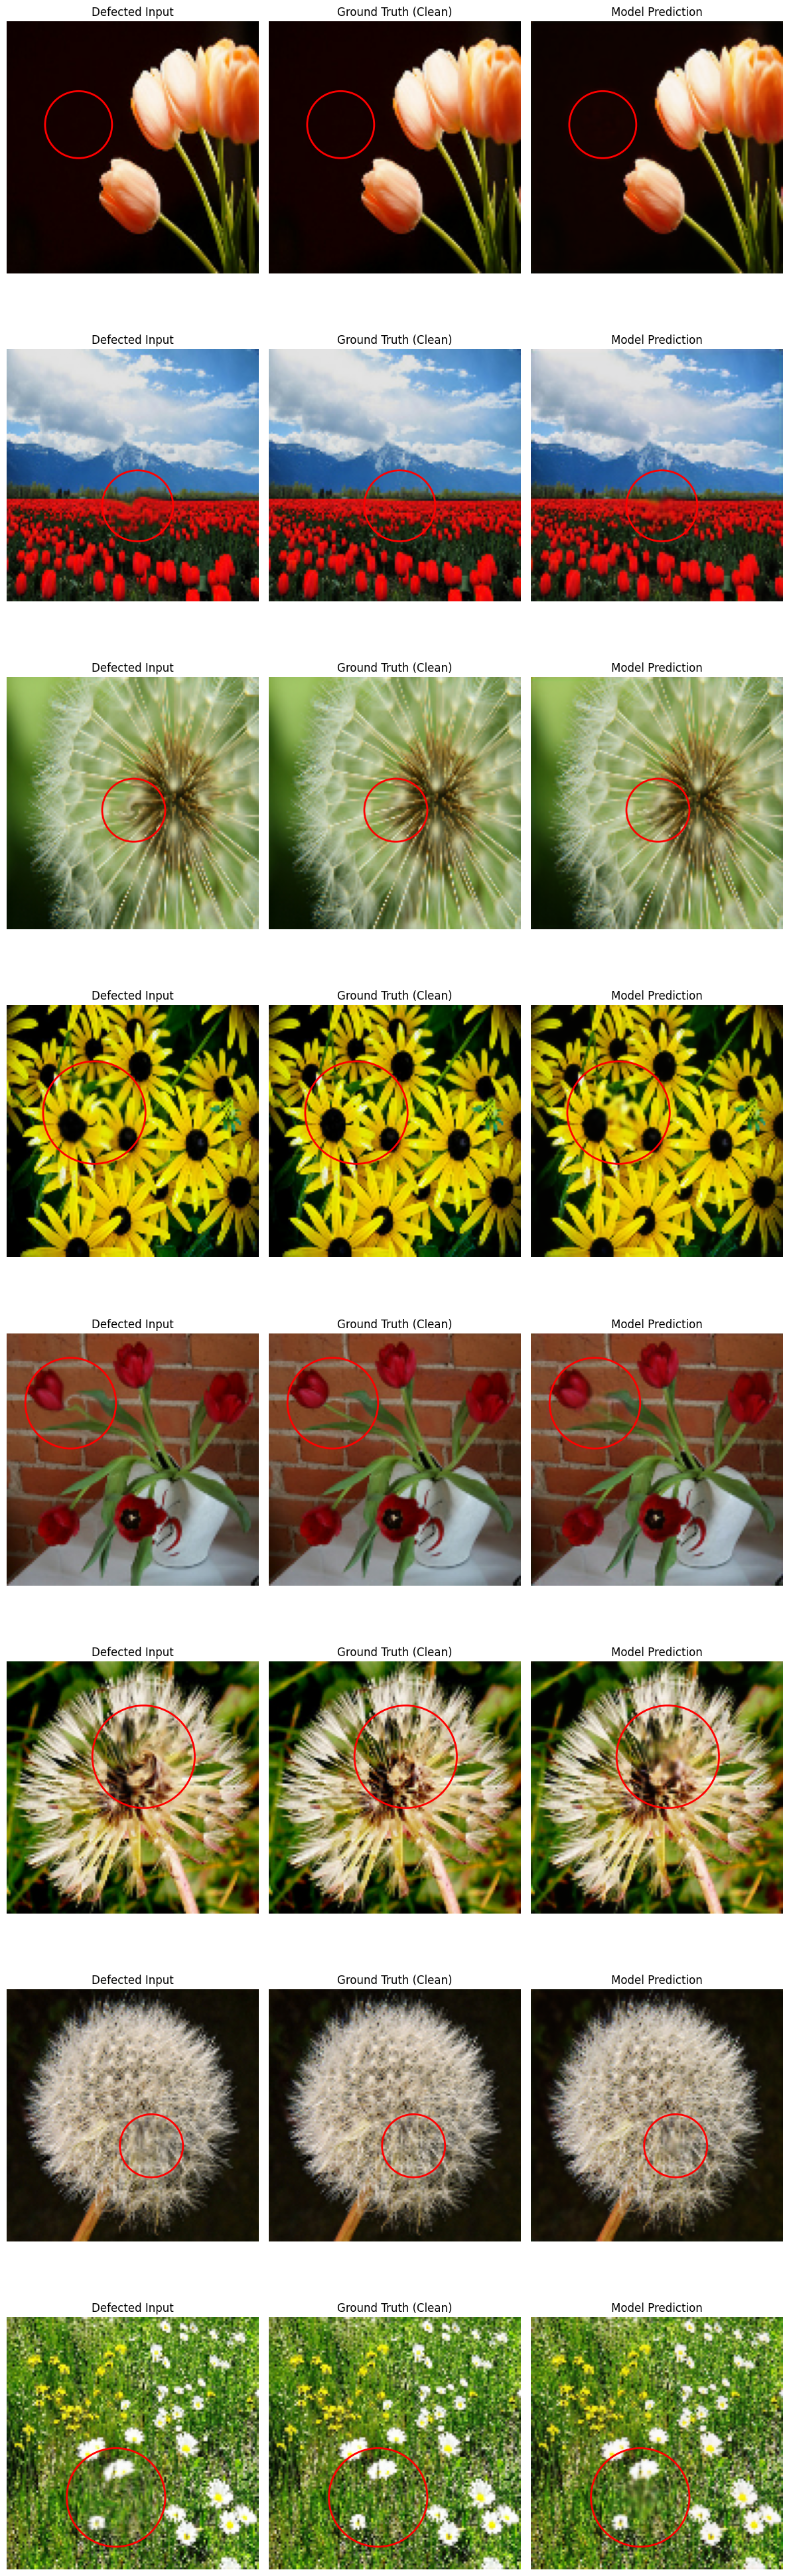

In [ ]:
from matplotlib.patches import Circle

x_defected, x_clean = test_gen[0]  # shape: (batch, H, W, 4)
inpaint_preds = model_inpaint.predict(x_defected)

n = min(8, len(x_defected))
plt.figure(figsize=(12, 5 * n))

for i in range(n):
    rgb_input = x_defected[i][:, :, :3]
    mask = x_defected[i][:, :, 3]  # shape: (H, W), values in [0, 1]
    
    ys, xs = np.where(mask > 0.5)

    if len(xs) > 0:
        center_x = int(np.mean(xs))
        center_y = int(np.mean(ys))
        radius = int(np.sqrt(len(xs) / np.pi))  

    # Subplot 1: Defected image
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(rgb_input)
    plt.title("Defected Input")
    plt.axis('off')
    if len(xs) > 0:
        ax = plt.gca()
        circ = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
        ax.add_patch(circ)

    # Subplot 2: Ground truth
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_clean[i][:, :, :3])
    plt.title("Ground Truth (Clean)")
    plt.axis('off')
    if len(xs) > 0:
        ax = plt.gca()
        circ = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
        ax.add_patch(circ)

    # Subplot 3: Prediction
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(np.clip(inpaint_preds[i], 0, 1))
    plt.title("Model Prediction")
    plt.axis('off')
    if len(xs) > 0:
        ax = plt.gca()
        circ = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
        ax.add_patch(circ)

plt.tight_layout()
plt.show()

The two-stage pipeline successfully reconstructs defected regions, with the model prediction closely matching the ground truth clean image. However, the inpainting network introduces slight blurriness, particularly in high-frequency patterns like fine grass textures within the corrected area. To address this limitation, I experimented with perceptual losses using VGG features to better preserve texture details, but these approaches did not yield significant performance improvements over the standard pixel-wise loss function used in the final implementation.

# Evaluation metric



Let us compute this "initial" error:

In [36]:
# Select a batch from the test generator
idx = np.random.randint(0, len(test_gen) - 1)
x_batch_defected, x_batch_clean = test_gen[idx]
# Compute initial distance between swirled image and original for the batch
initial_mse_imgs = np.mean((x_batch_defected[:, :, :, :3] - x_batch_clean[:, :, :, :3])**2*x_batch_defected[:, :, :, 3:],axis=(1,2,3))
initial_mse_batch = np.mean(initial_mse_imgs)
print(f"Initial error introduced by swilr: {initial_mse_batch:.4f}")

Initial error introduced by swilr: 0.0008


In [37]:
# Predict the repaired images
generated_images = model_inpaint.predict(x_batch_defected)

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - x_batch_clean[:, :, :, :3])**2*x_batch_defected[:, :, :, 3:],axis=(1,2,3))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/initial_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Average score (Generated / Initial): 0.2079


In [38]:
n_batches = len(test_gen_mask_predict)
batch_scores = []

for idx in range(n_batches):
    x_in, y_gt = test_gen_mask_predict[idx]
    x_def  = x_in[..., :3]
    mask_pred = x_in[..., 3:]
    y_clean   = y_gt[..., :3]


    gen = model_inpaint.predict(x_in, verbose=0)

    initial_mse_imgs   = np.mean((x_def - y_clean)**2 * mask_pred, axis=(1,2,3))
    initial_mse_batch  = np.mean(initial_mse_imgs)

    generated_mse_imgs = np.mean((gen  - y_clean)**2 * mask_pred, axis=(1,2,3))
    generated_mse_batch= np.mean(generated_mse_imgs)


    mean_ratio = generated_mse_batch / initial_mse_batch
    batch_scores.append(mean_ratio)

    print(f"Batch {idx:03d} ratio:", mean_ratio)


mean_over_batches = np.mean(batch_scores)
std_over_batches  = np.std(batch_scores)

print(f"\nFinal MEAN over batches: {mean_over_batches:.4f}")
print(f"Final STD  over batches: {std_over_batches:.4f}")

params = model_inpaint.count_params() + mask_predictor.count_params()
params_str = f"{params:,}"


df = pd.DataFrame({
    "NAME": ["matildesimonini"],
    "MEAN": [mean_over_batches],
    "STD":  [std_over_batches],
    "PARAMETERS": [params_str]
})

print(df.to_markdown(index=False))

Batch 000 ratio: 0.24482405
Batch 001 ratio: 0.21560034
Batch 002 ratio: 0.24369502
Batch 003 ratio: 0.25799674
Batch 004 ratio: 0.21737736
Batch 005 ratio: 0.2168046
Batch 006 ratio: 0.2120549
Batch 007 ratio: 0.23189631
Batch 008 ratio: 0.2690602
Batch 009 ratio: 0.21149926
Batch 010 ratio: 0.27877283

Final MEAN over batches: 0.2363
Final STD  over batches: 0.0231
| NAME            |     MEAN |       STD | PARAMETERS   |
|:----------------|---------:|----------:|:-------------|
| matildesimonini | 0.236326 | 0.0230891 | 3,996,350    |


## Conclusions

This project implemented a two-stage deep learning pipeline for automatic defect detection and image restoration. The mask prediction network achieved strong positive results, accurately identifying swirl-defected regions. The inpainting network effectively reconstructs damaged areas using a U-Net architecture with skip connections, leveraging the insight that most output pixels should remain unchanged from the input.

The complete pipeline demonstrates robust end-to-end functionality, automatically detecting defects and restoring images without requiring manual mask annotation. However, training the correction network proved challenging due to frequent loss plateauing, requiring careful callback tuning and extended training epochs (70 vs 50 for mask prediction). The current approach also exhibits limitations in preserving high-frequency details, resulting in slight blurriness in fine textures.

Since the project didn't have to deal with image labels, concerns about label preservation that typically complicate augmentation in supervised tasks weren't a problem. This allowed to choose for the simplest data augmentation strategy consisting in flipping images. 
Alternative augmentation techniques were explored, including extracting and resizing patches from original images to create additional training samples. However, this approach led to overfitting, likely due to the reduced spatial context and altered image statistics that disrupted the learning process.

### Future improvements

Several promising directions could enhance the pipeline's performance and address current limitations. To improve texture preservation, adversarial training with GANs could be implemented to generate more realistic high-frequency details.
Architectural improvements could include attention mechanisms to dynamically focus on defected regions, transformer-based models for better global context understanding, or multi-scale processing to handle defects of varying sizes.

Another potential improvement would involve better shuffling strategies to ensure augmented variants of the same original image are distributed throughout different training batches rather than appearing consecutively. This could reduce overfitting by preventing the model from learning to associate specific augmented patterns with particular source images during training.